# Optimistic initial values

Initial action values can be used as a simple way to encourage exploration. Suppose to set an initial estimate in a wildly optimistic way. Whichever actions are initially selected, the reward is less than the starting estimates, and the learner switches to other actions, being "disappointed" with the rewards it is receiving. The result is that all actions are tried several times before the value estimates converge. The system does a fair amount of exploration even if greedy actions are selected all the time.

In [2]:
import numpy as np

class BanditEnv:
    def __init__(self):
        """10-armed testbed"""
        self.size = 10                                        # 10 arms
        self.means = np.random.randn(self.size)
        
    def step(self, action):
        return np.random.normal(loc=self.means[action])
    
env = BanditEnv()

In [3]:
def decay_epsilon_greedy(env, init_epsilon=1.0, 
                         min_epsilon=0.01, decay_ratio=0.05, 
                         n_episodes=1000):
    Q = np.zeros((env.size), dtype=np.float64)
    N = np.zeros((env.size), dtype=int)
    Qe = np.empty((n_episodes, env.size), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    decay_episodes = int(n_episodes * decay_ratio)
    rem_episodes = n_episodes - decay_episodes
    epsilons = 0.01
    epsilons /= np.logspace(-2, 0, decay_episodes)
    epsilons *= init_epsilon - min_epsilon
    epsilons += min_epsilon
    epsilons = np.pad(epsilons, (0, rem_episodes), 'edge')
    for e in range(n_episodes):
        if np.random.uniform() > epsilons[e]:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))
        reward = env.step(action)    
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        Qe[e] = Q
        returns[e] = reward
    return returns, Qe

In [10]:
def optimistic_initialization(env, optimistic_estimate=5.0,
                              initial_count=10, n_episodes=1000):
    
    # start initializing the Q-values to an optimistic value
    Q = np.full((env.size), optimistic_estimate, dtype=np.float64)
    
    # initialize the counts that will serve as an uncertainty measure
    # the higher the more certain.
    N = np.full((env.size), initial_count, dtype=int)
    
    Qe = np.empty((n_episodes, env.size), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)

    for e in range(n_episodes):
        
        action = np.argmax(Q)

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]

        Qe[e] = Q
        returns[e] = reward
        
    return returns, Qe

In [11]:
from tqdm import tqdm

returns_epsilon_decay = []
returns_optimistic = []

for i in tqdm(range(2000), desc='Running epsilon decay'):
    returns, _ = decay_epsilon_greedy(env=env) 
    returns_epsilon_decay.append(returns); 
    
for i in tqdm(range(2000), desc='Running optmistic method'):
    returns, _ = optimistic_initialization(env=env)
    returns_optimistic.append(returns); 

returns_epsilon_decay = np.array(returns_epsilon_decay)
returns_optimistic = np.array(returns_optimistic)

Running optmistic method: 100%|████████████| 2000/2000 [00:13<00:00, 153.71it/s]


In [12]:
# Average reward
avg_reward_epsilon_decay = np.average(returns_epsilon_decay, axis=0)
avg_reward_optimistic = np.average(returns_optimistic, axis=0)

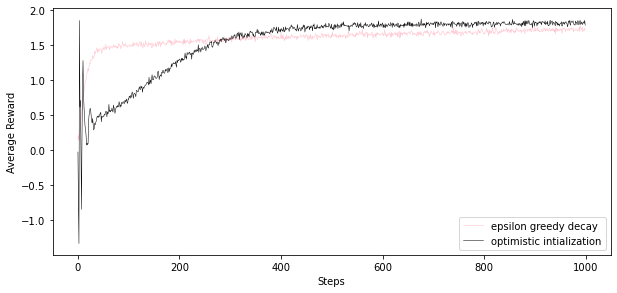

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

plt.subplot(2, 1, 1)
plt.plot(avg_reward_epsilon_decay, linewidth=0.5, color='pink',   label='epsilon greedy decay')
plt.plot(avg_reward_optimistic, linewidth=0.5, color='black',   label='optimistic intialization')
plt.xlabel('Steps');
plt.ylabel('Average Reward')
plt.legend()

plt.show()